In [1]:
%matplotlib inline
import networkx as nx


# 第 3 章

目次：

1. [ハブを見つける](#Finding-hubs)
2. [中心性分布](#Centrality-distributions)
3. [頑健性のテスト](#Testing-robustness)

## 1.ハブを見つける

ネットワークを見るとき、多くの場合、最も「重要な」ノードを見つけたい。重要さの定義は様々である。中心性の最も基本的な尺度は、*次数*、つまりノードに接続されたリンクの数である。

Enron社幹部陣の電子メールのグラフを見てみよう。


Graph with 143 nodes and 623 edges


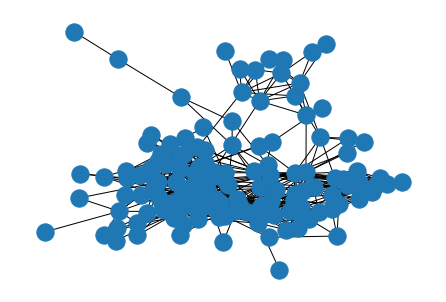

In [2]:
G = nx.read_edgelist('../datasets/ia-enron-only/ia-enron-only.edges', nodetype=int)
print(nx.info(G))
nx.draw(G)


### 注意事項: デフォルトでは、 `nx.read_edgelist` はノード名が文字列であると仮定する

エッジのリストは、グラフを格納するための単純なプレーン・テキスト形式である。この単純なファイル形式にはデータ型に関する情報が含まれていないため、すべてのノード名はデフォルトで文字列と見なされる。この例のように、ノード名が整数で指定されている場合、ノード名との混乱を避けるために `nodetype=int` キーワード引数を指定する必要がある。

### 余談: `max` 関数

次数が最も大きいノードを見つけるために、Python の組み込みの `max` 関数を使用する。

まず、 `max` 関数の機能を思い出してみよう。最も基本的なものとして、 `max` 関数はシーケンス内の「最大の」アイテムを返す。


In [3]:
max([1,2,3,4,5])

5


しかし、「最大の」アイテムの根拠が常に明白であるとは限らない。


In [4]:
max(['apple', 'grape', 'carrot'])

'grape'


`grape`他の選択肢より大きいのはなぜだろう？文字列のデフォルトのソートは辞書順 (基本的にはアルファベット順) である。このデフォルトの順序付けが不都合な場合は、キー関数を指定して、アイテムを比較する方法を Python に指示する。


In [5]:
max(['apple', 'grape', 'carrot'], key=len)

'carrot'


ここではアイテムを長さで比較しているため、 `carrot` が最大の要素になる。

### 次数が最大のノードを見つける

`max` 関数を適用して、いくつかの基準に従って最大ノードを取得できる。この場合、次数でノードを比較すれば、最大次数のノードを取得できる。


In [6]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

105

In [7]:
G.degree(highest_degree_node)

42


これにより、ノード `105` には 42 個のエッジが接続されていることがわかる。その計算をもう少し詳しく見てみよう。

前述の文では、*キー*引数 `G.degree` を渡し、 `G.nodes`の中 から最大のアイテムが必要であることを `max` 関数に伝えている。

`G.degree` は関数なので、この文が正常に動く。媒介性などの他の中心性の尺度は、すべてのノードの中心性の値を一度に生成してしまい、 `dict` を返す。このような場合、追加の手順が必要である。


In [8]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

105

In [9]:
betweenness[highest_betweenness_node]

0.19400604344556296


次のように設定した場合、エラーが発生することに注意してほしい。


In [10]:
max(G.nodes, key=betweenness)

TypeError: 'dict' object is not callable


これは、 `キー`引数に関数を与える必要がある一方で、 `betweenness` という辞書を与えてしまっためである。これを回避するには、dict の `get` メソッドを使用したい。



## 2. 中心性の分布

ネットワークで最も中心的なノードを見つけたが、すべてのノードの中心性に関する情報を要約したいとことがある。例えば、最大次数に加え、ネットワークの中心性の平均値と中央値が必要になることがよくある。

この情報を要約するための最初のステップは、グラフ内のすべての中心性の値のシーケンスを取得することである。ノード名はこだわらず、数のシーケンスだけが必要なのである。次数の例から始めよう。


In [11]:
degree_sequence = [G.degree(n) for n in G.nodes]


このシーケンスの平均と中央値を取得するには、Python の組み込み `statistics` モジュールを使用する。


In [12]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

Mean degree: 8.713286713286713
Median degree: 8



ネットワーク全体に対して一度に計算され、辞書を返す他の中心性の尺度については、辞書の `.values()` を使用する。


In [13]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.013950388838012454
Median betweenness: 0.0037492834763570323



### 分布のプロット

*ヒストグラム*を使用して、中心性の値のシーケンスをグラフィカルに表すことができる。基本的な形式では、ヒストグラムは x 軸に次数の値を、y 軸にその次数を持つノードの数をプロットする。このカウントを行うために、Python の `collections.Counter` が利用できる。


In [14]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({30: 1,
         2: 16,
         17: 5,
         12: 5,
         13: 3,
         16: 5,
         10: 9,
         11: 10,
         18: 3,
         20: 1,
         15: 3,
         19: 2,
         7: 9,
         14: 6,
         9: 16,
         42: 1,
         8: 6,
         5: 8,
         6: 7,
         1: 6,
         4: 11,
         23: 1,
         3: 9})


返される `Counter` オブジェクトは `dict` のようなもので、カウントされた項目とシーケンスに表示された回数をペアにする。

この基本的なヒストグラム・プロットでは、シーケンス内の最小度と最大度の間のすべての整数の x 値が必要である。 `degree_counts.keys()` は、次数シーケンスで見られるすべての個別の値を提供することに注意したい。また、適切なエンドポイントを含めるため、以下の `range` に +1 が必要であることに注意する。


In [15]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))


y 値は、次数シーケンスで各 x 値を数えた回数である。シーケンスに表示されない次数、例えば、32 は上記の `degree_counts` に表示されないため、`degree_counts.get(32, 0)`で 0 が得られる。

In [16]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]


プロットをするには、Matplotlib の `pyplot` モジュールを使用する。


<BarContainer object of 42 artists>

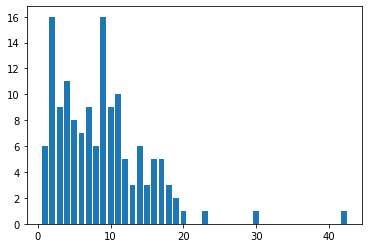

In [17]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)


### ヒストグラムのビニング

快適に表示できる以上の x 値がある場合、または媒介中心性の場合のように、中心性の尺度が離散的でない場合は、ヒストグラムの「ビニング」が用いられる。これは、 *bins* とよばれる互いに素な間隔のシーケンスを定義し、そのような各ビンに入る値の数をカウントするだけである。最も単純なケースでは、matplotlib.pyplot の `hist` 関数に必要なビンの数を伝えるだけで、ビニングが実行される。


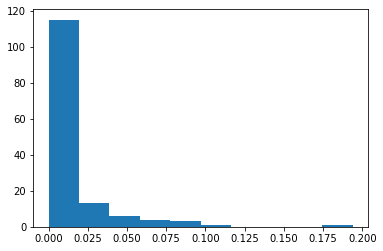

In [18]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)


必要に応じて、返された `bins` と `counts` を調査できる。


In [19]:
bins

array([0.        , 0.0194006 , 0.03880121, 0.05820181, 0.07760242,
       0.09700302, 0.11640363, 0.13580423, 0.15520483, 0.17460544,
       0.19400604])

In [20]:
counts

array([115.,  13.,   6.,   4.,   3.,   1.,   0.,   0.,   0.,   1.])


これらから、0 から 0.0194006 の間に 115 個の値、0.194006 から 0.3880121 の間に 13 個の値があることなどがわかる。



## 3. 頑健性のテスト

ネットワーク内のノードの相対的な「重要性」について考えるもう 1 つの方法は、特定のノードを削除した場合にネットワーク構造がどの程度損なわれるかを測定することである。現実社会では、ノードの削除は、人が引っ越して社会的ネットワークから離れたり、転職して電子メールがネットワークから外れたり、インターネット・ルーターが攻撃されたり過負荷になってダウンしたり、などが考えられる。

大きく分けて、ランダム障害と標的型攻撃の 2 種類のネットワーク損傷を考えてみよう。ランダム障害では、削除するノードがランダムに選択される一方で、標的型攻撃では、いくつかの基準に基づいてノードが削除される。例えば、次数中心性の大きい順にノードが削除される。

### 連結成分

「損傷」を測定するために、ネットワークの最大連結成分 (*コア*とよばれる) のサイズを測定する。まず、`nx.connected_components` は連結成分を一度にひとつずつ与えるジェネレータであることを確認する。


In [21]:
nx.connected_components(G)

<generator object connected_components at 0x00000295B04986D0>


コア、または最大連結成分だけがほしいことが多いため、 `next`関数を使用して、ジェネレーターから最初の項目だけを取得すればいい。各成分は、ノード名のセットとして与えられる。


In [22]:
core = next(nx.connected_components(G))
core

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143}


このセットの `len` がこの連結成分内のノードの数を示す。


In [23]:
len(core)

143


すべての連結成分が必要な場合は、それらのリストを取得できる。


In [24]:
components = list(nx.connected_components(G))


このリストの長さがグラフの連結成分の数である。


In [25]:
len(components)

1


### ランダム障害

ネットワークを破壊するよう処理をするときはいつも、ネットワークのコピーを作成しておき、元の状態に簡単に戻れるようにしておきたい。


In [26]:
C = G.copy()


ランダムな障害をシミュレートするために、いくつかのノード名をランダムに選択し、グラフから削除する。 一度に複数のノードを削除するには`random.sample` が使用できる。ただし、ランダムにサンプリングするノード名の `list` を作成する必要がある。


In [27]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)


完全なシミュレーションは、ネットワークの新しいコピーから始めて、次の手順を踏む：

1. ネットワークのコアのサイズを測定し、元のネットワークと比較する
2. M 個のノードをランダムに選択して削除する
3. ノード数が M 個未満になるまで繰り返す



このプロセスに必要なステップ数から M 算出する。約 25 ステップが妥当と思われるので、次のように決める。


In [28]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5


各ステップで削除されたノードの総数のシーケンスを、`range` を使用して生成できる。


In [29]:
num_nodes_removed = range(0, G.number_of_nodes(), M)


ループはいたってシンプルである。各ステップで、コアに残っているノードの割合を記録すればよい。


In [30]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

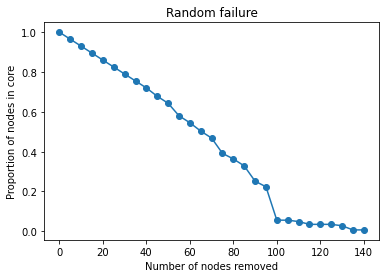

In [31]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')


#### 標的型攻撃

標的型攻撃のシミュレーションも同様だが、ランダムに選択する代わりに、各ステップで 最も中心的な M個のノードを選択する。これを達成するには、最上位の M 個のノードを取得できる `max` 関数のようなものが必要となる。 Python の `sorted` 関数を `max` と同様の方法で使用して、最初にノードの中心性の降順（逆順ともよばれる）でソートする。次数でソートしたら、リストの最初の M 個のノードを取得する。


In [32]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
top_degree_nodes

[105, 17, 95, 48, 132]


その点を考慮すると、ループはかなり似たように見える。ここですべてのピースをまとめてみたい。


In [33]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # ネットワーク・コアの相対的なサイズを測定
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # M個以上のノードがある場合、上位M個のノードを選択し、削除する
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

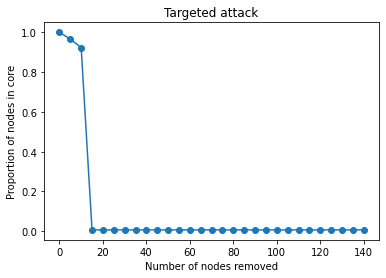

In [34]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')


見てのとおり、効果はランダム障害に比べて歴然としている。グラフ内の比較的少数の中央ノードを削除するだけで、ネットワークは完全に切断される。

Pyplot は、2 つの方法で攻撃を行った結果の曲線を同じプロットに描くことができる。


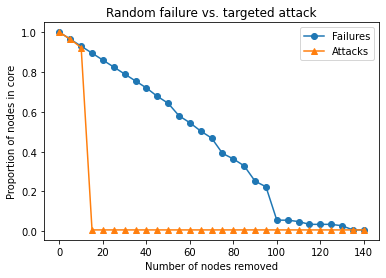

In [35]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()